# Классификация текстов

## Сеть прямого распространения  для классификации текстов


![title](img/mlp.png)

* $x$ - входное векторное представление текста
* $h$ – скрытые слои с нелинейными функциями активации
* $y$ – выходы, как правило, один $y$ соответствует одной метке класса 

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$h_2 = g^2(h^1 W^2 + b^2)$

$y = h^2 W^3$

### Нелинейные функции активации

![title](img/activation.png)

### dropout-регуляризация

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$m^1 ~ Bernouli(r^1)$

$\hat{h^1} = m^1 \odot h^1$

$h_2 = g^2(\hat{h^1} W^2 + b^2)$

$m^2 ~ Bernouli(r^2)$

$\hat{h^2} = m^2 \odot h^2$

$y =\hat{h^2} W^3$



### Векторное представление текста 
* BOW (bag of words) – разреженное (sparse) векторное представление текста
* CBOW (continious bag of words)  – плотное (dense) векторное представление текста

$w_i$ – слово, $d_{emb}$ – размерность эмбеддинга слова, $E_{[w_i]}$ = $\textbf{w}_i$


#### Padding
Входные тексты имеют переменную длинну, что неудобно, поэтому предположим, что они все состоят из одинакового количества слов, только часть из этих слов – баластные символы pad/


#### Неизвестные слова (OOV)
Если в тестовом множестве встретилось неизвестное слово, то можно 
* заменить его на pad;
* заменить его на unk.  Однако в обучающем множестве unk никогда не встречается, поэтому его нужно добавить в обучающее множество искусственным образом. 


#### Word dropout - регуляризация 
Заменяем каждое слово на unk с вероятностью $\frac{\alpha}{|V| + \alpha}$


In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/NLP/data/izvestya/articles_lemmatized_noSW.csv")
data = data[data.topic.isin(("Культура", "Общество", "Политика", "Экономика", "Спорт"))] 
train_corpus = pd.DataFrame(columns=data.columns)
test_corpus = pd.DataFrame(columns=data.columns)

for topic in data.topic.unique():
    corpus_sample = data[data.topic==topic].sample(110)
    train_corpus = train_corpus.append(corpus_sample.iloc[:100, :])
    test_corpus = test_corpus.append(corpus_sample.iloc[100:, :])

In [3]:
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 300
DIMS = 250
MAX_FEATURES = 5000
batch_size = 32

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 10

## Сеть прямого распространения

In [4]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_corpus.body)
tokenizer

In [5]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [6]:
print('First seq:',sequences[0])
print('First doc:',X_train[0])

First seq: [3905, 4712, 3, 25, 1906, 1853, 18, 3149, 622, 920, 741, 2, 65, 298, 2036, 203, 1473, 3720, 2979, 1093, 4755, 3110, 1069, 642, 3100, 904, 3694, 107, 835, 1325, 536, 1739, 3200, 1807, 2050, 1202, 298, 109, 811, 140, 842, 298, 329, 138, 2867, 642, 3224, 1342, 4765, 4941, 282, 922, 1831, 213, 501, 914, 2, 3088, 90, 3901, 4693, 95, 3008, 842, 1193, 3324, 1831, 298, 407, 3299, 3354, 320, 233, 357, 463, 647, 309, 19, 49, 90, 1498, 2431, 463, 3166, 1020, 794, 203, 109, 1812, 3157, 4946, 998, 4701, 406, 2, 1675, 4712, 3905, 107, 914, 3100, 3384, 413, 599, 298, 95, 15, 1617, 3209, 109, 727, 794, 3772, 338, 1068, 485, 811, 1232, 1093, 46, 73, 4358, 1473, 109, 4855, 1214, 535, 3772, 2711, 4437, 217, 139, 1020, 95, 4609, 1833, 3341, 1794, 3156, 786, 323, 99, 1099, 575, 643, 1667, 3008, 2773, 2720, 1338, 3752, 918, 4642, 1739, 1429, 535, 725, 99, 575, 338, 3089, 82, 922, 696, 2247, 115, 918, 1812, 4609, 240, 1446, 2431, 436, 817, 2, 2635, 849, 1807, 1014, 786, 3110, 1, 455, 4646, 1631, 2

In [7]:
le = LabelEncoder()
le.fit(train_corpus.topic.unique())
y_train = np_utils.to_categorical(le.transform(train_corpus.topic), 5)
y_test = np_utils.to_categorical(le.transform(test_corpus.topic), 5)
y_true = le.transform(test_corpus.topic)
print(y_train[0])

[ 1.  0.  0.  0.  0.]


In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 0s 945us/step - loss: 1.3166 - acc: 0.5444 - val_loss: 1.5953 - val_acc: 0.3200
Epoch 2/10
450/450 [==============================] - 0s 428us/step - loss: 0.4497 - acc: 0.9556 - val_loss: 1.0057 - val_acc: 0.7000
Epoch 3/10
450/450 [==============================] - 0s 384us/step - loss: 0.1779 - acc: 0.9956 - val_loss: 0.8888 - val_acc: 0.7400

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 640,773
Trainable params: 640,773
Non-trainable params: 0
_________________________________________________________________


             precision    recall  f1-score   support

          0       0.90      0.90      0.90        10
          1       0.67      0.80      0.73        10
          2       0.78      0.70      0.74        10
          3       1.00      1.00      1.00        10
          4       0.89      0.80      0.84        10

avg / total       0.85      0.84      0.84        50



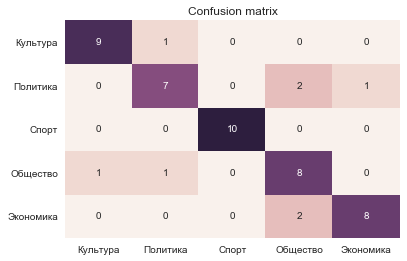

In [10]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))
labels = test_corpus.topic.unique()
y_true = le.inverse_transform(y_true)
y_pred = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [11]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [12]:
X_train[0]

array([   0,    0,    0, ...,   24, 2237, 3674], dtype=int32)

In [13]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 31s 69ms/step - loss: 9.6101 - acc: 0.1956 - val_loss: 16.1181 - val_acc: 0.0000e+00

In [14]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

             precision    recall  f1-score   support

   Культура       0.86      0.60      0.71        10
   Общество       0.43      1.00      0.61        10
   Политика       0.67      0.80      0.73        10
      Спорт       1.00      0.80      0.89        10
  Экономика       0.00      0.00      0.00        10

avg / total       0.59      0.64      0.59        50



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


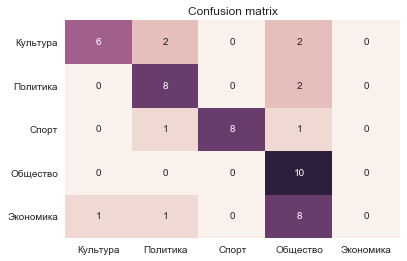

In [15]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [16]:
%%time

import numpy as np
emb_path = '/NLP/embeddings/wiki.ru.vec'

words = []

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 2min 34s, sys: 7.14 s, total: 2min 41s
Wall time: 2min 45s


In [17]:
print(len(embeddings_index))

1775997


In [18]:
word_index = tokenizer.word_index
len(word_index)

31889

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)


Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 2s 4ms/step - loss: 1.5713 - acc: 0.4956 - val_loss: 3.7053 - val_acc: 0.0000e+00

In [21]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

             precision    recall  f1-score   support

   Культура       0.86      0.60      0.71        10
   Общество       0.57      0.80      0.67        10
   Политика       0.64      0.90      0.75        10
      Спорт       1.00      0.90      0.95        10
  Экономика       1.00      0.60      0.75        10

avg / total       0.81      0.76      0.76        50



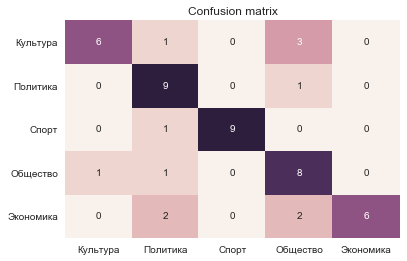

In [22]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Сверточные нейронные сети [Convolutional neural networks, CNN]

* Заимствованы из области компьютерного зрения
* Пик популярности пришелся на 2014 (до +10% аккуратности в задачах классификации), со временем были вытеснены рекуррентными нейронными сетями 
* Помогают справится  с проблемой переменной длины входов (CNN VS window-based NN)

### Слой свертки

#### Фильтр [filter]:
* $w_{1,n}$ – последовательность слов, $k$  – размер окна
* $w_i$ , $d_{emb}$ – размерность эмбеддинга слова,  $\textbf{w}_i \in \mathbb{R}^{d_{emb}} $
* $\textbf{x}_i = [\textbf{w}_{i}, \textbf{w}_{i+1}, \ldots, \textbf{w}_{i+k-1}]$, $\textbf{x}_i \in \mathbb{R}^{k d_{emb}}$

Фильтр: $p_i = g(\textbf{x}_i  u)$, $p_i \in \mathbb{R}$, $u \in \mathbb{R}^{k d_{emb}}$


![title](img/cnn1.png)


Преобразуем каждое входное окно, но пока размерность входа не уменьшается!

#### Слой субдискретизации (пулинга, [pooling])

* $h_i$ – выходные значения фильтра

$\max$-пулинг:	$c = \max_i h_i$


![title](img/cnn2.png)

* Выбираем самый важный признак из полученных на предыдущем шаге 
* Можем использовать и $\min$, и усреднение



### Классификатор на основе сверточной сети

* $y \in [0,1] $ - истинные значения
* $\widehat{y} = c$ - предсказанные значения

![title](img/cnn3.png)

Для обучения сверточной сети можно использовать обычный алгоритм распространения ошибки

Одномерные фильтры – это сильное ограничение. Что делать, если $c=0.5$?

#### Многомерные фильтры

Используем $\textit{l}$ разных фильтров: $u_{1}, \ldots, u_{\textit{l}}$: 

$\textbf{x}_i = [\textbf{w}_{i}, \textbf{w}_{i+1}, \ldots, \textbf{w}_{i+k-1}]$

$\textbf{p}_i = g(\textbf{x}_i \cdot  U+b)$

$\textbf{p}_i \in \mathbb{R}^{\textit{l}} $, $\textbf{x}_i \in \mathbb{R}^{k d_{emb}}$, $U \in \mathbb{R}^{k d_{emb} \times \textit{l}}$, $b \in \mathbb{R}^{\textit{l}} $

![title](img/cnn4.png)


$\max$-пулинг:	$c_j = \max_i h_{i,j}, j \in [0,\textit{l}]$


#### Шаг окна 
Можно использовать непересекающиеся окна, чтобы уменьшить объем вычисления

![title](img/cnn5.png)

### Как выбирать вектора слов? 
* Случайная инициализация (если нет обученных моделей word2vec, GloVe)
* word2vec, GloVe без обновления
* word2vec, GloVe c обновлением на каждой эпохе (увеличивается количество параметров!)
* Несколько каналов: копируем два входа и
    * на один подаем word2vec и не обновляем эти входы во время обучения, на второй подаем word2vec и обновляем эти входы во время обучения
    * на один вход подаем word2vec, на второй – GloVe

### Как использовать pad?

[[мое первое короткое предложение], [второе очень длинное предложение, которое никогда не заканчивается], [третье предложение]]

* Неэффективный способ: одно предложение – одна эпоха
* Окружить все предложения баластными символами pad и сделать их одной длины
* Надо убедиться, что $\max$-пулинг не выберет значения, соответствующие pad
* Надо убрать выбросы, то есть, супер-длинные предложения, возникшие, например, из-за ошибок сегментатора

## Классификация текстов с помощью CNN



![title](img/cnn6.png)

Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

![title](img/cnn7.png)

Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

In [23]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                            EMBEDDING_DIM,
                            input_length=TEXT_LENGTH,
                            trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   Культура       0.00      0.00      0.00        10
   Общество       0.00      0.00      0.00        10
   Политика       0.00      0.00      0.00        10
      Спорт       0.20      1.00      0.33        10
  Экономика       0.00      0.00      0.00        10

avg / total       0.04      0.20      0.07        50



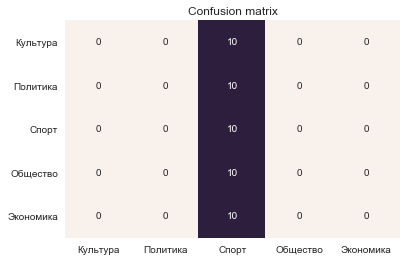

In [25]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()